<a href="https://colab.research.google.com/github/ivykhanhvy/BACE-MoleculeNet/blob/main/BACE_DMPNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 13.1 MB/s eta 0:00:00


In [ ]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
  try:
    import chemprop
  except ImportError:
    !git clone https://github.com/chemprop/chemprop.git
    %cd chemprop
    !pip install .
    %cd examples

Cloning into 'chemprop'...
remote: Enumerating objects: 25120, done.
remote: Counting objects: 100% (276/276), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 25120 (delta 168), reused 93 (delta 93), pack-reused 24844 (from 3)
Receiving objects: 100% (25120/25120), 863.55 MiB | 24.85 MiB/s, done.
Resolving deltas: 100% (17991/17991), done.
Updating files: 100% (325/325), done.
/content/chemprop
Processing /content/chemprop
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [ ]:
from pathlib import Path

from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import deepchem as dc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from rdkit import Chem

from chemprop import data, featurizers, models, nn

In [ ]:
tasks, datasets, transformers = dc.molnet.load_bace_regression(featurizer='ECFP', split='random')

[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerator
[23:04:23] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
print(datasets[0])
mf = datasets[0].X
pIC50 = datasets[0].y
smiles = datasets[0].ids
print(mf[:10])
print(pIC50[:10])
print(smiles[:10])

<DiskDataset X.shape: (np.int64(1210), np.int64(1024)), y.shape: (np.int64(1210), np.int64(1)), w.shape: (np.int64(1210), np.int64(1)), task_names: ['pIC50']>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[-1.60771738]
 [ 0.74686797]
 [ 0.65232893]
 [-1.56528436]
 [-0.10517684]
 [-2.24524882]
 [-1.11491576]
 [-1.57665008]
 [-0.09771729]
 [-0.63325686]]
['s1cc(cc1)-c1cc2c(nc(N)cc2)cc1'
 's1cc(cc1)C1(N=C(N)N(C)C1=O)c1cc(-c2cccnc2F)c(F)cc1'
 'Fc1ccc(cc1-c1cncnc1)C1(N=C(N)N(C)C1=O)c1cn(nc1)CC'
 'O(CC1CC1)c1cc(ccc1)-c1ccc(cc1)C1CC1C=1N=C(N)N(C)C(=O)C=1'
 'Fc1c2c(ccc1)C(N=C2N)(c1cc(ccc1)-c1cncnc1)c1cc(OC)ncc1'
 'Clc1cc2nc(n(c2cc1)C(CC(=O)NCCC1CC[NH2+]C1)CC)N'
 'O1c2c(cc(N3CCCCC3)cc2)C2(N=C(N)N(C)C2=O)CC1(C)C'
 'O1C2CCCCC2(N=C1N)c1cc(ccc1)-c1cncnc1'
 'Fc1cc(cc(F)c1)CC(NC(=O)C)C(O)C[NH2+]C1(CCCCC1)c1nnn(c1)C12CC3CC(C1)CC(C2)C3'
 'Fc1cc(cc(F)c1)CC(NC(=O)c1cc(cc(c1)C(=O)N(CCC)CCC)CC(OC)

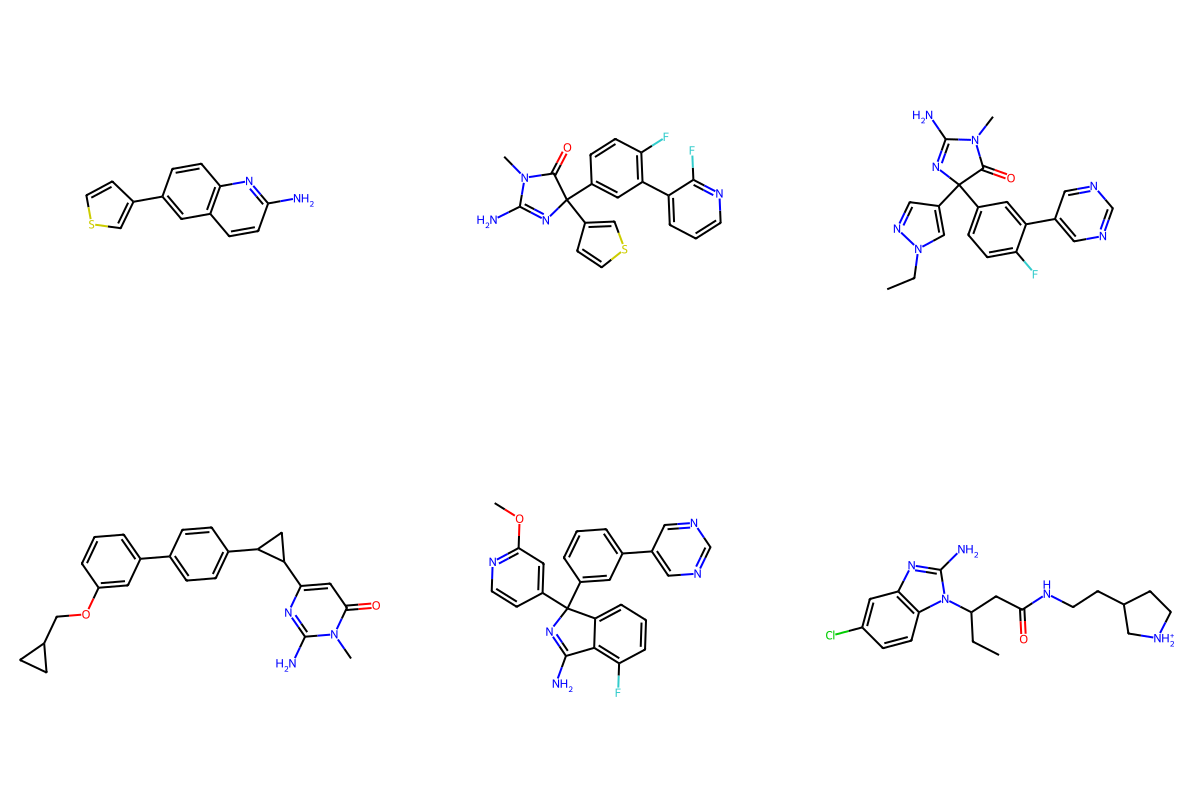

In [ ]:
mols = [Chem.MolFromSmiles(smi) for smi in smiles]

img = Chem.Draw.MolsToGridImage(mols[:6], molsPerRow=3, subImgSize=(400, 400))
img

In [ ]:
all_data = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smiles, pIC50)]
print(all_data[1])

MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x783163cb4c80>, y=array([0.74686797]), weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='s1cc(cc1)C1(N=C(N)N(C)C1=O)c1cc(-c2cccnc2F)c(F)cc1', V_f=None, E_f=None, V_d=None)


In [ ]:
train_indices, valid_indices, test_indices = data.make_split_indices(mols, "scaffold_balanced", (0.8,0.1,0.1))
print(train_indices)
print(len(train_indices))
print(len(train_indices[0]))
train_data, valid_data, test_data = data.split_data_by_indices(all_data,train_indices,valid_indices,test_indices)
print(train_data[0])
print(len(train_data))
print(len(train_data[0]))

[[np.int64(238), np.int64(662), np.int64(142), np.int64(817), np.int64(902), np.int64(441), np.int64(9), np.int64(15), np.int64(122), np.int64(154), np.int64(232), np.int64(449), np.int64(464), np.int64(503), np.int64(584), np.int64(589), np.int64(643), np.int64(648), np.int64(714), np.int64(751), np.int64(778), np.int64(990), np.int64(1021), np.int64(1123), np.int64(1134), np.int64(537), np.int64(270), np.int64(892), np.int64(360), np.int64(474), np.int64(234), np.int64(126), np.int64(70), np.int64(230), np.int64(899), np.int64(1202), np.int64(1182), np.int64(340), np.int64(590), np.int64(748), np.int64(947), np.int64(97), np.int64(181), np.int64(358), np.int64(942), np.int64(178), np.int64(280), np.int64(538), np.int64(874), np.int64(1146), np.int64(243), np.int64(559), np.int64(941), np.int64(48), np.int64(580), np.int64(921), np.int64(507), np.int64(111), np.int64(253), np.int64(258), np.int64(688), np.int64(802), np.int64(159), np.int64(132), np.int64(191), np.int64(292), np.int64

/usr/local/lib/python3.11/dist-packages/astartes/samplers/extrapolation/scaffold.py:48: NoMatchingScaffold: No matching scaffold was found for the 4 molecules corresponding to indices {965, 1020, 732, 925}
  warnings.warn(


In [ ]:
#get molecule dataset and normalize regression data
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset(train_data[0], featurizer)
scaler = train_dset.normalize_targets()

valid_dset = data.MoleculeDataset(valid_data[0], featurizer)
valid_dset.normalize_targets(scaler) #scale based on the mean and std of the train set

test_dset = data.MoleculeDataset(test_data[0], featurizer) #not scale yet
print(train_dset)
print(train_dset[0])
print(len(train_dset)) # of atoms in train set (dtype: MoleculeDataset)
print(len(train_dset[0])) # Datum object includeing MolGraph, y, w, etc.
print(len(train_dset[0][0])) # MolGraph object: v, e, edge_index, rev_edge_index
print(len(train_dset[0][0][0])) # Vertices represenative (based on # of atoms in smiles)
print(len(train_dset[0][0][0][0])) # Feature of vertices (set at 72)

print(len(train_dset[1][0][0]))
print(len(train_dset[1][0][0][0]))

print(len(train_dset[2][0][0]))
print(len(train_dset[2][0][0][0]))

MoleculeDataset(data=[MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x783163d09e70>, y=array([-0.15735294]), weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='Clc1cc2CC(N=C(NC(Cc3ccccc3)C=3NC(=O)C(=CN=3)C#N)c2cc1)(C)C', V_f=None, E_f=None, V_d=None), MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x783163d295b0>, y=array([-0.23207893]), weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='IC1=CN=C(NC1=O)C(NC1=NC(Cc2c1ccc(Cl)c2)(C)C)Cc1ccccc1', V_f=None, E_f=None, V_d=None), MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x783163d049e0>, y=array([1.53817706]), weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='Fc1cc(cc(F)c1)CC(NC(=O)C(N1CCC(NC(=O)C)(C(CC)C)C1=O)CCc1ccccc1)C(O)C1[NH2+]CC(OCc2cc(ccc2)C(F)(F)F)C1', V_f=None, E_f=None, V_d=None), MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x783163d35e70>, y=array([1.50355319]), weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='Fc

In [ ]:
#convert dataset to torch to input in nn
train_loader = data.build_dataloader(train_dset, num_workers= 0) #default shuffle
valid_loader = data.build_dataloader(valid_dset, num_workers= 0, shuffle = False)
test_loader = data.build_dataloader(test_dset, num_workers= 0, shuffle = False)

print(train_loader)
print(train_loader.dataset)
print(train_loader.dataset[0])
#Datum: contain graphs, features, target, weights, etc.
#train_loader.dataset[0][0] contains the graph featurizer (V, E, edge_index, and each row describe each atom)

MoleculeDataset(data=[MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x783163d09e70>, y=array([-0.15735294]), weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='Clc1cc2CC(N=C(NC(Cc3ccccc3)C=3NC(=O)C(=CN=3)C#N)c2cc1)(C)C', V_f=None, E_f=None, V_d=None), MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x783163d295b0>, y=array([-0.23207893]), weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='IC1=CN=C(NC1=O)C(NC1=NC(Cc2c1ccc(Cl)c2)(C)C)Cc1ccccc1', V_f=None, E_f=None, V_d=None), MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x783163d049e0>, y=array([1.53817706]), weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='Fc1cc(cc(F)c1)CC(NC(=O)C(N1CCC(NC(=O)C)(C(CC)C)C1=O)CCc1ccccc1)C(O)C1[NH2+]CC(OCc2cc(ccc2)C(F)(F)F)C1', V_f=None, E_f=None, V_d=None), MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x783163d35e70>, y=array([1.50355319]), weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='Fc

In [ ]:
mp = nn.BondMessagePassing()
agg = nn.SumAggregation()
fnn = nn.RegressionFFN()
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
fnn = nn.RegressionFFN(output_transform=output_transform)
batch_norm = True
metric_list = [nn.metrics.RMSE(), nn.metrics.MAE()]

mpnn = models.MPNN(mp, agg, fnn, batch_norm, metric_list)
mpnn

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): SumAggregation()
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (metrics): ModuleList(
    (0): RMSE(task_weights=[[1.0]])
    (1): MAE(task_weight

In [ ]:
checkpoint = ModelCheckpoint("checkpoints", # directory to save checkpoints
                             "best-{epoch}-{val_loss:.2f}", #file name
                             "val_loss", #metrics evaluation
                             mode = "min", # save checkpoint with the lowest validation loss
                             save_last = True) # save with most recent checkpoint

trainer = pl.Trainer(logger = False,
                     enable_checkpointing = True,
                     enable_progress_bar = True,
                     devices = 1,
                     max_epochs = 20,
                     callbacks = [checkpoint])

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(mpnn, train_loader, valid_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/chemprop/examples/checkpoints exists and is not empty.
INFO: Loading `train_dataloader` to estimate number of stepping batches.
INFO:lightning.pytorch.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | SumAggregation     | 0      | train
2 | bn              | BatchNorm1d        | 600    | train
3 | predictor       | RegressionFFN      | 90.6 K | train
4 | X_d_transform   | Identity           | 0      | train
5 | metrics         | ModuleList         | 0      | train
---------------------------------------------------------------
318 K     Trainable params
0         Non-trainable params
318 K     Total params
1.276     Total e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
results = trainer.test(dataloaders = test_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at /content/chemprop/examples/checkpoints/best-epoch=18-val_loss=0.25.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/chemprop/examples/checkpoints/best-epoch=18-val_loss=0.25.ckpt
INFO: Loaded model weights from the checkpoint at /content/chemprop/examples/checkpoints/best-epoch=18-val_loss=0.25.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/chemprop/examples/checkpoints/best-epoch=18-val_loss=0.25.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.4379861056804657     │
│         test/rmse         │    0.5801177024841309     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
test_prediction = trainer.predict(mpnn, test_loader)
print(test_prediction)

Predicting: |          | 0/? [00:00<?, ?it/s]

[tensor([[-4.1541e-01],
        [-1.6599e+00],
        [ 6.3351e-01],
        [-2.6659e-01],
        [-3.2712e-02],
        [-1.6057e+00],
        [-1.5589e+00],
        [-1.5976e+00],
        [-1.5417e+00],
        [-1.5268e+00],
        [-1.5546e+00],
        [-1.9806e+00],
        [-1.2018e+00],
        [-1.3840e+00],
        [-1.5281e+00],
        [-1.1997e+00],
        [-1.5084e+00],
        [-1.6228e+00],
        [ 2.9693e-01],
        [ 5.5836e-01],
        [ 1.6963e-01],
        [-4.3739e-01],
        [ 8.7887e-01],
        [-7.4662e-01],
        [ 4.8333e-01],
        [ 1.9039e-03],
        [-1.4492e+00],
        [-7.4168e-01],
        [-2.6239e-01],
        [-6.9227e-01],
        [ 7.3989e-01],
        [ 1.3890e+00],
        [ 7.6499e-01],
        [-5.0758e-01],
        [-1.0200e-01],
        [-7.1844e-01],
        [-1.2152e-01],
        [ 6.2884e-01],
        [ 7.5286e-02],
        [-2.6074e-01],
        [-3.8473e-01],
        [ 8.1511e-02],
        [-5.1859e-01],
        [ 

In [ ]:
y_pred = np.concatenate(test_prediction, axis = 0)
y_pred = np.squeeze(y_pred)

y_true = [d.y[0] if isinstance(d.y, (list, np.ndarray)) else d.y for d in test_data[0]]
y_true = np.array(y_true)

print(max(y_true))
print(min(y_true))
print(y_true)
print(y_pred)

1.7313382958284693
-2.6755274251934265
[-5.38717369e-01 -1.46848874e+00  5.86981594e-01 -3.15285173e-01
  6.06399574e-01 -1.45393957e+00 -1.97600750e+00 -1.16866463e+00
 -1.45663307e+00 -1.39965558e+00 -1.61276016e+00 -1.47106601e+00
 -1.19347830e+00 -1.43871643e+00 -1.71634847e+00 -1.33846161e+00
 -1.13116437e+00 -1.27969736e+00 -4.29382724e-03 -1.52318769e+00
 -1.52318769e+00 -4.91691199e-01  1.69020678e+00 -5.16044810e-01
  6.13622438e-01  7.36092622e-01 -1.13116437e+00 -2.26461375e-01
 -2.26461375e-01  2.48070000e-02  1.27576816e+00  1.53817706e+00
  6.86952802e-01  1.23428358e-01 -1.42423725e+00 -1.91884220e+00
  3.13970777e-01 -2.14929341e-01  5.00979929e-02 -4.36793080e-01
 -3.41056434e-01 -3.98832756e-01  1.40284580e-01  8.80113579e-01
  8.48792638e-01  8.80113579e-01  1.73133830e+00 -1.80396937e+00
  1.18122867e+00 -1.38994209e+00 -1.27506879e+00 -1.69562612e+00
 -2.08340913e+00 -1.48734420e+00 -1.50285390e+00 -1.31865893e+00
 -1.44012969e+00 -7.97823793e-01 -1.40283078e+00 -1

In [ ]:
df = pd.DataFrame({
    "y_true": y_true,
    "y_predict": y_pred
})

print(df.head())
r2_value = r2_score(df["y_true"],df["y_predict"])
print(f"R2: {r2_value:.4f}")

     y_true  y_predict
0 -0.538717  -0.415410
1 -1.468489  -1.659898
2  0.586982   0.633514
3 -0.315285  -0.266589
4  0.606400  -0.032712
R2: 0.6906


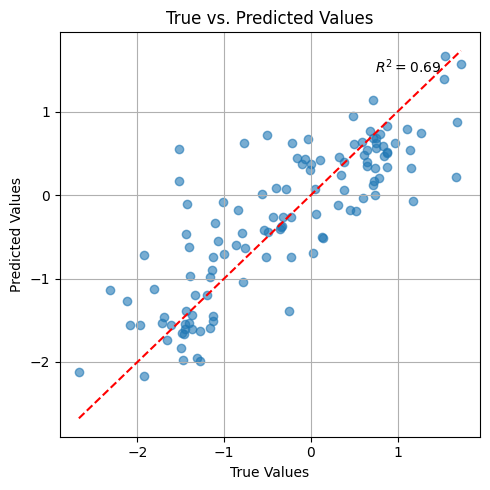

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--') # y=x
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values")
plt.text(0.75, 0.9, f'$R^2 = {r2_value:.2f}$', transform=plt.gca().transAxes)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 11.1 MB/s eta 0:00:00


In [ ]:
import ray
from ray import tune
from ray.train import CheckpointConfig, RunConfig, ScalingConfig
from ray.train.lightning import (RayDDPStrategy, RayLightningEnvironment,
                                 RayTrainReportCallback, prepare_trainer)
from ray.train.torch import TorchTrainer
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import FIFOScheduler

In [ ]:
def train_model(config, train_dset, valid_dset, num_workers, scaler):
  depth = int(config["depth"])
  ffn_hidden_dim = int(config["ffn_hidden_dim"])
  ffn_num_layers = int(config["ffn_num_layers"])
  message_hidden_dim = int(config["message_hidden_dim"])

  train_loader = data.build_dataloader(train_dset, num_workers= num_workers)
  valid_loader = data.build_dataloader(valid_dset, num_workers= num_workers, shuffle = False)

  mp = nn.BondMessagePassing(d_h=message_hidden_dim, depth=depth)
  agg = nn.SumAggregation()
  output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
  ffn = nn.RegressionFFN(output_transform=output_transform, input_dim=message_hidden_dim, hidden_dim=ffn_hidden_dim, n_layers=ffn_num_layers)
  batch_norm = True
  metric_list = [nn.metrics.RMSE(), nn.metrics.MAE()]
  model = models.MPNN(mp, agg, ffn, batch_norm, metric_list)

  trainer = pl.Trainer(
      accelerator="auto",
      devices=1,
      max_epochs=20, # number of epochs to train for
      # below are needed for Ray and Lightning integration
      strategy=RayDDPStrategy(),
      callbacks=[RayTrainReportCallback()],
      plugins=[RayLightningEnvironment()],
  )

  trainer = prepare_trainer(trainer)
  trainer.fit(model, train_loader, valid_loader)

In [ ]:
search_space = {
    "depth": tune.qrandint(lower=2, upper=6, q=1),
    "ffn_hidden_dim": tune.qrandint(lower=300, upper=2400, q=100),
    "ffn_num_layers": tune.qrandint(lower=1, upper=3, q=1),
    "message_hidden_dim": tune.qrandint(lower=300, upper=2400, q=100),
}

In [ ]:
num_workers = 0
hpopt_save_dir = Path.cwd() / "hpopt" # directory to save hyperopt results
hpopt_save_dir.mkdir(exist_ok=True)

In [ ]:
ray.shutdown()
ray.init(ignore_reinit_error=True)

Epoch 18:  25%|██▌       | 4/16 [00:20<01:01,  0.20it/s, v_num=0, train_loss_step=0.207, val_loss=0.391, train_loss_epoch=0.297] [repeated 2x across cluster]


2025-06-10 00:48:45,623	INFO worker.py:1888 -- Started a local Ray instance.


Python version:,3.11.13
Ray version:,2.46.0


In [ ]:
scheduler = FIFOScheduler()

# Scaling config controls the resources used by Ray
scaling_config = ScalingConfig(
    num_workers=1,
    use_gpu=False, # change to True if you want to use GPU
)

# Checkpoint config controls the checkpointing behavior of Ray
checkpoint_config = CheckpointConfig(
    num_to_keep=1, # number of checkpoints to keep
    checkpoint_score_attribute="val_loss", # Save the checkpoint based on this metric
    checkpoint_score_order="min", # Save the checkpoint with the lowest metric value
)

run_config = RunConfig(
    checkpoint_config=checkpoint_config,
    storage_path=hpopt_save_dir / "ray_results", # directory to save the results
)

ray_trainer = TorchTrainer(
    lambda config: train_model(
        config, train_dset, valid_dset, num_workers, scaler
    ),
    scaling_config=scaling_config,
    run_config=run_config,
)

search_alg = HyperOptSearch(
    n_initial_points=1, # number of random evaluations before tree parzen estimators
    random_state_seed=42,
)

# OptunaSearch is another search algorithm that can be used
# search_alg = OptunaSearch()

tune_config = tune.TuneConfig(
    metric="val_loss",
    mode="min",
    num_samples=5, # number of trials to run
    scheduler=scheduler,
    search_alg=search_alg,
    trial_dirname_creator=lambda trial: str(trial.trial_id), # shorten filepaths

)

tuner = tune.Tuner(
    ray_trainer,
    param_space={
        "train_loop_config": search_space,
    },
    tune_config=tune_config,
)

# Start the hyperparameter search
results = tuner.fit()


2025-06-10 00:48:51,977	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+---------------------------------------------------------------------+
| Configuration for experiment     TorchTrainer_2025-06-10_00-48-51   |
+---------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                    |
| Scheduler                        FIFOScheduler                      |
| Number of trials                 5                                  |
+---------------------------------------------------------------------+

View detailed results here: /content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51

Trial status: 1 PENDING
Current time: 2025-06-10 00:48:52. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hi

(TorchTrainer pid=28635) Started distributed worker processes: 
(TorchTrainer pid=28635) - (node_id=097333a180598f814203bcc376deded70783ef2a21b4101368078fb0, ip=172.28.0.12, pid=28724) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=28724) Setting up process group for: env:// [rank=0, world_size=1]



Trial status: 1 RUNNING | 1 PENDING
Current time: 2025-06-10 00:49:22. Total running time: 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim |
+--------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_f0a35203   RUNNING                         2                     2000                        2                      500 |
| TorchTrainer_f4b42cb4   PENDING                         2                     2200                        2                      400 |
+--------------------------------------------------------------------------------------------------------------------------------------+

Trial TorchTrainer_f4b42cb4 started 

(TrainTrainable pid=28725) Trainable.setup took 10.549 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(RayTrainWorker pid=28724) Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
(RayTrainWorker pid=28724) GPU available: False, used: False
(RayTrainWorker pid=28724) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=28724) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=28724) 2025-06-10 00:49:25.141389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=28724) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(RayTrainWorker pid=28724) E0000 00:00:1749516565.196826   28884 cuda_dnn.cc:8310] Unable to reg

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:  50%|█████     | 8/16 [00:09<00:09,  0.85it/s, v_num=0, train_loss_step=0.577]


(RayTrainWorker pid=28879) Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
(RayTrainWorker pid=28879) GPU available: False, used: False
(RayTrainWorker pid=28879) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=28879) HPU available: False, using: 0 HPUs


Epoch 0:  56%|█████▋    | 9/16 [00:10<00:08,  0.87it/s, v_num=0, train_loss_step=0.395]


(RayTrainWorker pid=28879) 2025-06-10 00:49:42.617587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=28879) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(RayTrainWorker pid=28879) E0000 00:00:1749516582.670026   28995 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(RayTrainWorker pid=28879) E0000 00:00:1749516582.688574   28995 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 0: 100%|██████████| 16/16 [00:15<00:00,  1.01it/s, v_num=0, train_loss_step=0.715]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


(RayTrainWorker pid=28879) Loading `train_dataloader` to estimate number of stepping batches.
(RayTrainWorker pid=28879) /usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=28879) 
(RayTrainWorker pid=28879)   | Name            | Type               | Params | Mode 
(RayTrainWorker pid=28879) ---------------------------------------------------------------
(RayTrainWorker pid=28879) 0 | message_passing | BondMessagePassing | 383 K  | train
(RayTrainWorker pid=28879) 1 | agg             | SumAggregation     | 0      | train
(RayTrainWorker pid=28879) 2 | bn              | BatchNorm1d        | 800    | train
(RayTrainWorker pid=28879) 3 | predictor       | RegressionFFN      | 5.7 M  | train
(RayTrainWorker pid=28879) 4 | X_d_transform   | Identity     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.64it/s]
(RayTrainWorker pid=28724) 
Epoch 0:   0%|          | 0/16 [00:00<?, ?it/s] 


(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000000)


Epoch 1:   6%|▋         | 1/16 [00:01<00:25,  0.59it/s, v_num=0, train_loss_step=0.348, val_loss=1.120, train_loss_epoch=0.636] [repeated 2x across cluster]

Trial status: 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:49:52. Total running time: 1min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f0a35203 with val_loss=1.1193643808364868 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2000, 'ffn_num_layers': 2, 'message_hidden_dim': 500}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+------------------------------------------------------------------

(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000000)


Epoch 1:   6%|▋         | 1/16 [00:01<00:22,  0.67it/s, v_num=0, train_loss_step=0.360, val_loss=0.993, train_loss_epoch=0.643]
(RayTrainWorker pid=28724) 
Epoch 1: 100%|██████████| 16/16 [00:17<00:00,  0.89it/s, v_num=0, train_loss_step=0.403, val_loss=1.120, train_loss_epoch=0.636] [repeated 2x across cluster]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.10it/s]
(RayTrainWorker pid=28724) 
Epoch 1: 100%|██████████| 16/16 [00:19<00:00,  0.81it/s, v_num=0, train_loss_step=0.403, val_loss=0.469, train_loss_epoch=0.636]


(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000001)


Epoch 1: 100%|██████████| 16/16 [00:13<00:00,  1.20it/s, v_num=0, train_loss_step=0.355, val_loss=0.993, train_loss_epoch=0.643]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s]
(RayTrainWorker pid=28879) 
Epoch 1: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, v_num=0, train_loss_step=0.355, val_loss=1.180, train_loss_epoch=0.643]


2025-06-10 00:50:21,837	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000001)


Epoch 1: 100%|██████████| 16/16 [00:15<00:00,  1.00it/s, v_num=0, train_loss_step=0.355, val_loss=1.180, train_loss_epoch=0.494]
Trial status: 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:50:22. Total running time: 1min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f0a35203 with val_loss=0.46947377920150757 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2000, 'ffn_num_layers': 2, 'message_hidden_dim': 500}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+---------------------------------------------------------------------------------------------

(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000002)


Epoch 2: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s, v_num=0, train_loss_step=1.370, val_loss=1.180, train_loss_epoch=0.494]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.18it/s]
(RayTrainWorker pid=28879) 
Epoch 2: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, v_num=0, train_loss_step=1.370, val_loss=0.629, train_loss_epoch=0.494]


(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000002)


Epoch 3: 100%|██████████| 16/16 [00:16<00:00,  0.96it/s, v_num=0, train_loss_step=0.208, val_loss=0.634, train_loss_epoch=0.535]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.73it/s]
(RayTrainWorker pid=28724) 
Epoch 3: 100%|██████████| 16/16 [00:17<00:00,  0.89it/s, v_num=0, train_loss_step=0.208, val_loss=0.535, train_loss_epoch=0.535]


(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000003)


Epoch 3:  94%|█████████▍| 15/16 [00:12<00:00,  1.16it/s, v_num=0, train_loss_step=0.253, val_loss=0.629, train_loss_epoch=0.498]
Trial status: 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:50:52. Total running time: 2min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f0a35203 with val_loss=0.5350937843322754 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2000, 'ffn_num_layers': 2, 'message_hidden_dim': 500}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+-----------------------------------------------------------------------------------------------

(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000003)


Epoch 4: 100%|██████████| 16/16 [00:17<00:00,  0.94it/s, v_num=0, train_loss_step=0.486, val_loss=0.535, train_loss_epoch=0.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4:  81%|████████▏ | 13/16 [00:10<00:02,  1.27it/s, v_num=0, train_loss_step=0.325, val_loss=0.757, train_loss_epoch=0.446] [repeated 10x across cluster]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:01<00:01,  0.90it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0: 100%|██████████| 2/2 [00:02<00:00,  0.90it/s]
(RayTrainWorker pid=28724) 
Epoch 4: 100%|██████████| 16/16 [00:19<00:00,  0.82it/s, v_num=0, train_loss_step=0.486, val_loss=0.514, train_loss_epoch=0.500]
(RayTrainWorker pid=28879) 


(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000004)
2025-06-10 00:51:09,087	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 4: 100%|██████████| 16/16 [00:20<00:00,  0.79it/s, v_num=0, train_loss_step=0.486, val_loss=0.514, train_loss_epoch=0.438]
(RayTrainWorker pid=28879) 
Epoch 5:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.486, val_loss=0.514, train_loss_epoch=0.438]
(RayTrainWorker pid=28879) 
Epoch 4: 100%|██████████| 16/16 [00:13<00:00,  1.21it/s, v_num=0, train_loss_step=0.386, val_loss=0.757, train_loss_epoch=0.446] [repeated 2x across cluster]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 16/16 [00:20<00:00,  0.80it/s, v_num=0, train_loss_step=0.386, val_loss=1.420, train_loss_epoch=0.436]


(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000004)


Epoch 5: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, v_num=0, train_loss_step=0.198, val_loss=0.514, train_loss_epoch=0.438]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
Trial status: 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:51:22. Total running time: 2min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f0a35203 with val_loss=0.514132022857666 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2000, 'ffn_num_layers': 2, 'message_hidden_dim': 500}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     tr

(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000005)


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s, v_num=0, train_loss_step=0.230, val_loss=1.420, train_loss_epoch=0.436]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  2.07it/s]
(RayTrainWorker pid=28879) 
Epoch 5: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s, v_num=0, train_loss_step=0.230, val_loss=0.455, train_loss_epoch=0.436]


(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000005)


Epoch 6: 100%|██████████| 16/16 [00:16<00:00,  0.95it/s, v_num=0, train_loss_step=0.399, val_loss=0.482, train_loss_epoch=0.409]
(RayTrainWorker pid=28724) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.72it/s]
(RayTrainWorker pid=28724) 
Epoch 6:  75%|███████▌  | 12/16 [00:11<00:03,  1.08it/s, v_num=0, train_loss_step=0.381, val_loss=0.455, train_loss_epoch=0.392] [repeated 8x across cluster]


2025-06-10 00:51:43,824	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000006)


Epoch 7:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.399, val_loss=0.440, train_loss_epoch=0.346]
(RayTrainWorker pid=28879) 
(RayTrainWorker pid=28879) 
(RayTrainWorker pid=28879) 
Epoch 6: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s, v_num=0, train_loss_step=0.379, val_loss=0.455, train_loss_epoch=0.392] [repeated 2x across cluster]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 16/16 [00:17<00:00,  0.90it/s, v_num=0, train_loss_step=0.379, val_loss=0.489, train_loss_epoch=0.334]


(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000006)


Epoch 7:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.379, val_loss=0.489, train_loss_epoch=0.334]
Trial status: 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:51:52. Total running time: 3min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f0a35203 with val_loss=0.44042348861694336 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2000, 'ffn_num_layers': 2, 'message_hidden_dim': 500}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+-------------------------------------------------------------------------------------------------------

2025-06-10 00:52:01,068	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000007)


Epoch 7: 100%|██████████| 16/16 [00:16<00:00,  0.95it/s, v_num=0, train_loss_step=0.317, val_loss=0.491, train_loss_epoch=0.346]
(RayTrainWorker pid=28879) 
(RayTrainWorker pid=28879) 
(RayTrainWorker pid=28879) 
Epoch 7: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s, v_num=0, train_loss_step=0.291, val_loss=0.489, train_loss_epoch=0.334] [repeated 2x across cluster]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s, v_num=0, train_loss_step=0.291, val_loss=0.569, train_loss_epoch=0.334]


(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000007)


Epoch 8: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s, v_num=0, train_loss_step=0.379, val_loss=0.569, train_loss_epoch=0.335]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.30it/s]
(RayTrainWorker pid=28879) 
Epoch 8:  81%|████████▏ | 13/16 [00:13<00:03,  0.94it/s, v_num=0, train_loss_step=0.340, val_loss=0.491, train_loss_epoch=0.346] [repeated 7x across cluster]
(RayTrainWorker pid=28879) 
Epoch 8: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s, v_num=0, train_loss_step=0.379, val_loss=0.363, train_loss_epoch=0.335]
Trial status: 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:52:22. Total running time: 3min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f0a35203 with val_loss=0.4912557899951935 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2000, 'ffn_num_layers

(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000008)


Epoch 9:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.379, val_loss=0.363, train_loss_epoch=0.344]
(RayTrainWorker pid=28724) 
(RayTrainWorker pid=28724) 
Epoch 8: 100%|██████████| 16/16 [00:17<00:00,  0.90it/s, v_num=0, train_loss_step=0.374, val_loss=0.491, train_loss_epoch=0.346] [repeated 2x across cluster]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 


2025-06-10 00:52:26,112	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 9: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s, v_num=0, train_loss_step=0.661, val_loss=0.363, train_loss_epoch=0.344]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Epoch 9:  62%|██████▎   | 10/16 [00:10<00:06,  0.93it/s, v_num=0, train_loss_step=0.228, val_loss=0.396, train_loss_epoch=0.340] [repeated 8x across cluster]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.07it/s]
(RayTrainWorker pid=28879) 
Epoch 9: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s, v_num=0, train_loss_step=0.661, val_loss=0.420, train_loss_epoch=0.344]


2025-06-10 00:52:38,887	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000009) [repeated 2x across cluster]


Epoch 9: 100%|██████████| 16/16 [00:16<00:00,  0.95it/s, v_num=0, train_loss_step=0.610, val_loss=0.396, train_loss_epoch=0.340]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.62it/s]
(RayTrainWorker pid=28724) 
Epoch 9: 100%|██████████| 16/16 [00:18<00:00,  0.88it/s, v_num=0, train_loss_step=0.610, val_loss=0.344, train_loss_epoch=0.340]


(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000009)


Epoch 10: 100%|██████████| 16/16 [00:09<00:00,  1.69it/s, v_num=0, train_loss_step=0.380, val_loss=0.420, train_loss_epoch=0.293]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s]
(RayTrainWorker pid=28879) 
Epoch 10: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, v_num=0, train_loss_step=0.380, val_loss=0.399, train_loss_epoch=0.278]


(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000010)


Trial status: 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:52:52. Total running time: 4min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f0a35203 with val_loss=0.34387969970703125 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2000, 'ffn_num_layers': 2, 'message_hidden_dim': 500}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+

(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000011)


Epoch 12:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.360, val_loss=0.367, train_loss_epoch=0.268]
(RayTrainWorker pid=28724) 
(RayTrainWorker pid=28724) 
Epoch 12:  12%|█▎        | 2/16 [00:01<00:12,  1.13it/s, v_num=0, train_loss_step=0.192, val_loss=0.367, train_loss_epoch=0.268] [repeated 4x across cluster]
(RayTrainWorker pid=28724) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


2025-06-10 00:53:10,725	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000010)


Epoch 12: 100%|██████████| 16/16 [00:09<00:00,  1.66it/s, v_num=0, train_loss_step=0.466, val_loss=0.367, train_loss_epoch=0.268]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s]
(RayTrainWorker pid=28879) 
Epoch 12: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s, v_num=0, train_loss_step=0.466, val_loss=0.357, train_loss_epoch=0.268]


(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000012)


Epoch 13:   6%|▋         | 1/16 [00:01<00:19,  0.76it/s, v_num=0, train_loss_step=0.245, val_loss=0.357, train_loss_epoch=0.263] [repeated 8x across cluster]
Trial status: 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:53:22. Total running time: 4min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.3566821813583374 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+-----------------------------------------------------------------

(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000011)
2025-06-10 00:53:33,189	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 12:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.252, val_loss=0.337, train_loss_epoch=0.289]
(RayTrainWorker pid=28879) 
(RayTrainWorker pid=28879) 
(RayTrainWorker pid=28879) 


2025-06-10 00:53:36,381	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 13: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s, v_num=0, train_loss_step=0.186, val_loss=0.357, train_loss_epoch=0.263] [repeated 2x across cluster]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 16/16 [00:18<00:00,  0.85it/s, v_num=0, train_loss_step=0.607, val_loss=0.337, train_loss_epoch=0.289]
Validation: |          | 0/? [00:00<?, ?it/s]
Trial status: 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:53:52. Total running time: 5min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.29753491282463074 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ...loop_config/depth     ...i

(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000012) [repeated 2x across cluster]


Epoch 13:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.607, val_loss=0.315, train_loss_epoch=0.282]
(RayTrainWorker pid=28879) 
(RayTrainWorker pid=28879) 
(RayTrainWorker pid=28879) 


2025-06-10 00:53:57,519	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 14: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, v_num=0, train_loss_step=0.322, val_loss=0.298, train_loss_epoch=0.265] [repeated 2x across cluster]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 16/16 [00:16<00:00,  0.95it/s, v_num=0, train_loss_step=0.177, val_loss=0.315, train_loss_epoch=0.282]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
(RayTrainWorker pid=28724) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.61it/s]
(RayTrainWorker pid=28879) 
(RayTrainWorker pid=28724) 
Epoch 13: 100%|██████████| 16/16 [00:18<00:00,  0.88it/s, v_num=0, train_loss_step=0.177, val_loss=0.457, train_loss_epoch=0.282]
(RayTrainWorker pid=28879) 


(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000015) [repeated 2x across cluster]
2025-06-10 00:54:18,843	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
2025-06-10 00:54:18,987	WARNING experiment_state.py:206 -- Experiment state snapshotting has been tri

Epoch 15: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s, v_num=0, train_loss_step=0.134, val_loss=0.275, train_loss_epoch=0.220] [repeated 2x across cluster]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.134, val_loss=0.345, train_loss_epoch=0.217]
Trial status: 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:54:22. Total running time: 5min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.3448912501335144 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage

2025-06-10 00:54:24,461	WARNING util.py:201 -- The `on_step_begin` operation took 1.130 s, which may be a performance bottleneck.


Epoch 16: 100%|██████████| 16/16 [00:11<00:00,  1.35it/s, v_num=0, train_loss_step=0.393, val_loss=0.345, train_loss_epoch=0.217]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]
(RayTrainWorker pid=28879) 
(RayTrainWorker pid=28879) 
Epoch 16: 100%|██████████| 16/16 [00:13<00:00,  1.23it/s, v_num=0, train_loss_step=0.393, val_loss=0.292, train_loss_epoch=0.217]


(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000016) [repeated 2x across cluster]
2025-06-10 00:54:33,749	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 14: 100%|██████████| 16/16 [00:16<00:00,  0.95it/s, v_num=0, train_loss_step=0.295, val_loss=0.457, train_loss_epoch=0.277]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s]
(RayTrainWorker pid=28724) 
Epoch 14: 100%|██████████| 16/16 [00:18<00:00,  0.89it/s, v_num=0, train_loss_step=0.295, val_loss=0.286, train_loss_epoch=0.277]


(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000014)
2025-06-10 00:54:46,103	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.078 s, which may be a performance bottleneck.
2025-06-10 00:54:46,105	WARNING util.py:201 -- The `process_trial_result` operation took 3.080 s, which may be a performance bottleneck.
2025-06-10 00:54:46,107	WARNING util.py:201 -- Processing trial results took 3.082 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-06-10 00:54:46,115	WARNING util.py:201 -- The `process_trial_result` operation took 3.090 s, which may be a performance bottleneck.
2025-06-10 00:54:46,206	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is for

Epoch 17: 100%|██████████| 16/16 [00:15<00:00,  1.02it/s, v_num=0, train_loss_step=0.230, val_loss=0.292, train_loss_epoch=0.213]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Epoch 15:  31%|███▏      | 5/16 [00:07<00:17,  0.64it/s, v_num=0, train_loss_step=0.193, val_loss=0.286, train_loss_epoch=0.235] [repeated 10x across cluster]
(RayTrainWorker pid=28879) 
Epoch 17: 100%|██████████| 16/16 [00:17<00:00,  0.93it/s, v_num=0, train_loss_step=0.230, val_loss=0.259, train_loss_epoch=0.213]


(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000017)


Trial status: 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:54:52. Total running time: 6min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.2585371732711792 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+


2025-06-10 00:55:02,770	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000015)


Epoch 18: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s, v_num=0, train_loss_step=0.115, val_loss=0.259, train_loss_epoch=0.207]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28879) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  2.01it/s]
(RayTrainWorker pid=28879) 
Epoch 18: 100%|██████████| 16/16 [00:16<00:00,  0.98it/s, v_num=0, train_loss_step=0.115, val_loss=0.290, train_loss_epoch=0.191]


(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000018)


Epoch 16:  94%|█████████▍| 15/16 [00:19<00:01,  0.78it/s, v_num=0, train_loss_step=0.283, val_loss=0.338, train_loss_epoch=0.232]
Trial status: 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:55:22. Total running time: 6min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.2899159789085388 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+---------------------------------------------------------------------------------------------

(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000016)
2025-06-10 00:55:24,935	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 17:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.316, val_loss=0.284, train_loss_epoch=0.224]
(RayTrainWorker pid=28879) 
(RayTrainWorker pid=28879) 
(RayTrainWorker pid=28879) 


2025-06-10 00:55:27,198	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=28879) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4/checkpoint_000019)


Epoch 19: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s, v_num=0, train_loss_step=0.308, val_loss=0.290, train_loss_epoch=0.191] [repeated 2x across cluster]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s, v_num=0, train_loss_step=0.276, val_loss=0.284, train_loss_epoch=0.224]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.67it/s]
(RayTrainWorker pid=28724) 
Epoch 17: 100%|██████████| 16/16 [00:11<00:00,  1.38it/s, v_num=0, train_loss_step=0.276, val_loss=0.280, train_loss_epoch=0.224]


2025-06-10 00:55:37,683	WARNING util.py:201 -- The `on_step_begin` operation took 1.270 s, which may be a performance bottleneck.
(RayTrainWorker pid=28879) `Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 16/16 [00:26<00:00,  0.61it/s, v_num=0, train_loss_step=0.308, val_loss=0.265, train_loss_epoch=0.182]


(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000017)
2025-06-10 00:55:38,212	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 18:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.276, val_loss=0.280, train_loss_epoch=0.217]

Trial TorchTrainer_f4b42cb4 completed after 20 iterations at 2025-06-10 00:55:38. Total running time: 6min 46s
+----------------------------------------------------------+
| Trial TorchTrainer_f4b42cb4 result                       |
+----------------------------------------------------------+
| checkpoint_dir_name                    checkpoint_000019 |
| time_this_iter_s                                15.90292 |
| time_total_s                                   362.47794 |
| training_iteration                                    20 |
| epoch                                                 19 |
| step                                                 320 |
| train_loss                                       0.18166 |
| train_loss_epoch                                 0.18166 |
| train_loss_step                                   0.3083 |
| val/mae                          

(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000018)


Epoch 19:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.239, val_loss=0.278, train_loss_epoch=0.206]


(TrainTrainable pid=30516) Trainable.setup took 10.446 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.



Trial TorchTrainer_86fcc58b started with configuration:
+---------------------------------------------+
| Trial TorchTrainer_86fcc58b config          |
+---------------------------------------------+
| train_loop_config/depth                   2 |
| train_loop_config/ffn_hidden_dim        600 |
| train_loop_config/ffn_num_layers          2 |
| train_loop_config/message_hidden_dim   2000 |
+---------------------------------------------+
Epoch 19:  50%|█████     | 8/16 [00:09<00:09,  0.87it/s, v_num=0, train_loss_step=0.238, val_loss=0.278, train_loss_epoch=0.206] [repeated 4x across cluster]


(TorchTrainer pid=30516) Started distributed worker processes: 
(TorchTrainer pid=30516) - (node_id=097333a180598f814203bcc376deded70783ef2a21b4101368078fb0, ip=172.28.0.12, pid=30632) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=30632) Setting up process group for: env:// [rank=0, world_size=1]


Epoch 19: 100%|██████████| 16/16 [00:15<00:00,  1.01it/s, v_num=0, train_loss_step=0.217, val_loss=0.278, train_loss_epoch=0.206]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=28724) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.80it/s]
(RayTrainWorker pid=28724) 
Epoch 19: 100%|██████████| 16/16 [00:17<00:00,  0.94it/s, v_num=0, train_loss_step=0.217, val_loss=0.300, train_loss_epoch=0.206]


(RayTrainWorker pid=28724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000019)


Epoch 19: 100%|██████████| 16/16 [00:17<00:00,  0.91it/s, v_num=0, train_loss_step=0.217, val_loss=0.300, train_loss_epoch=0.204]


(RayTrainWorker pid=28724) `Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 16/16 [00:18<00:00,  0.88it/s, v_num=0, train_loss_step=0.217, val_loss=0.300, train_loss_epoch=0.204]

Trial TorchTrainer_f0a35203 completed after 20 iterations at 2025-06-10 00:56:17. Total running time: 7min 25s
+----------------------------------------------------------+
| Trial TorchTrainer_f0a35203 result                       |
+----------------------------------------------------------+
| checkpoint_dir_name                    checkpoint_000019 |
| time_this_iter_s                                17.79614 |
| time_total_s                                   426.86355 |
| training_iteration                                    20 |
| epoch                                                 19 |
| step                                                 320 |
| train_loss                                        0.2037 |
| train_loss_epoch                                  0.2037 |
| train_loss_step                                  0.21682 |
| val/mae                 

(RayTrainWorker pid=30632) Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
(RayTrainWorker pid=30632) GPU available: False, used: False
(RayTrainWorker pid=30632) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=30632) HPU available: False, using: 0 HPUs



Trial status: 2 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-06-10 00:56:22. Total running time: 7min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.26483601331710815 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=30632) 2025-06-10 00:56:28.114648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=30632) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(RayTrainWorker pid=30632) E0000 00:00:1749516988.212706   30742 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(RayTrainWorker pid=30632) E0000 00:00:1749516988.242369   30742 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(RayTrainWorker pid=30632) Loading `train_dataloader` to estimate number of stepping batches.
(RayTrainWorker pid=30632) /usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (16) is s

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:07<00:07,  0.14it/s]

Trial TorchTrainer_69074113 started with configuration:
+---------------------------------------------+
| Trial TorchTrainer_69074113 config          |
+---------------------------------------------+
| train_loop_config/depth                   4 |
| train_loop_config/ffn_hidden_dim       2300 |
| train_loop_config/ffn_num_layers          1 |
| train_loop_config/message_hidden_dim    300 |
+---------------------------------------------+


(TrainTrainable pid=30780) Trainable.setup took 11.143 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Epoch 0:   0%|          | 0/16 [00:00<?, ?it/s] 


(TorchTrainer pid=30780) Started distributed worker processes: 
(TorchTrainer pid=30780) - (node_id=097333a180598f814203bcc376deded70783ef2a21b4101368078fb0, ip=172.28.0.12, pid=30928) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=30928) Setting up process group for: env:// [rank=0, world_size=1]



Trial status: 2 TERMINATED | 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:56:52. Total running time: 8min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.26483601331710815 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=30928) Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
(RayTrainWorker pid=30928) GPU available: False, used: False
(RayTrainWorker pid=30928) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=30928) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=30928) 2025-06-10 00:57:04.501744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=30928) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(RayTrainWorker pid=30928) E0000 00:00:1749517024.573889   31041 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(RayTrainWorker pid=30928) E0000 00:00:1749517024.597113   31041 cuda_

Epoch 0:  19%|█▉        | 3/16 [00:23<01:41,  0.13it/s, v_num=0, train_loss_step=0.503]


(RayTrainWorker pid=30928) Loading `train_dataloader` to estimate number of stepping batches.
(RayTrainWorker pid=30928) /usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=30928) 
(RayTrainWorker pid=30928)   | Name            | Type               | Params | Mode 
(RayTrainWorker pid=30928) ---------------------------------------------------------------
(RayTrainWorker pid=30928) 0 | message_passing | BondMessagePassing | 227 K  | train
(RayTrainWorker pid=30928) 1 | agg             | SumAggregation     | 0      | train
(RayTrainWorker pid=30928) 2 | bn              | BatchNorm1d        | 600    | train
(RayTrainWorker pid=30928) 3 | predictor       | RegressionFFN      | 694 K  | train
(RayTrainWorker pid=30928) 4 | X_d_transform   | Identity     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 0:  44%|████▍     | 7/16 [00:06<00:08,  1.09it/s, v_num=0, train_loss_step=0.662] [repeated 3x across cluster]
Trial status: 2 TERMINATED | 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:57:22. Total running time: 8min 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.26483601331710815 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+-----------------------------------

(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000000)
2025-06-10 00:57:30,627	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


(RayTrainWorker pid=30928) 
Epoch 1: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, v_num=0, train_loss_step=0.300, val_loss=0.702, train_loss_epoch=0.733]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.64it/s]
(RayTrainWorker pid=30928) 
Epoch 2:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.300, val_loss=0.566, train_loss_epoch=0.472]


(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000001)


Epoch 0:  50%|█████     | 8/16 [01:04<01:04,  0.12it/s, v_num=0, train_loss_step=0.566] [repeated 4x across cluster]
Trial status: 2 TERMINATED | 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:57:53. Total running time: 9min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.26483601331710815 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+---------------------------------------------------------------------------------------

(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000002)


Epoch 3: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, v_num=0, train_loss_step=0.434, val_loss=1.140, train_loss_epoch=0.482]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.75it/s]
(RayTrainWorker pid=30928) 
Epoch 3: 100%|██████████| 16/16 [00:16<00:00,  0.95it/s, v_num=0, train_loss_step=0.434, val_loss=0.864, train_loss_epoch=0.554]


(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000003)


Epoch 4:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.434, val_loss=0.864, train_loss_epoch=0.554]
Trial status: 2 TERMINATED | 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:58:23. Total running time: 9min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.26483601331710815 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+-----------------------------------------------------------------------------------

(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000004)


Epoch 0: 100%|██████████| 16/16 [02:02<00:00,  0.13it/s, v_num=0, train_loss_step=0.815]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=30632) 
Epoch 5:  81%|████████▏ | 13/16 [00:12<00:02,  1.01it/s, v_num=0, train_loss_step=0.550, val_loss=0.751, train_loss_epoch=0.411] [repeated 6x across cluster]
Trial status: 2 TERMINATED | 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:58:53. Total running time: 10min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.26483601331710815 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layer

(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000005)


Epoch 6:  19%|█▉        | 3/16 [00:02<00:12,  1.02it/s, v_num=0, train_loss_step=0.298, val_loss=0.626, train_loss_epoch=0.394]
(RayTrainWorker pid=30632) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:06<00:06,  0.16it/s]


(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000000)
2025-06-10 00:59:01,718	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 6: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s, v_num=0, train_loss_step=0.567, val_loss=0.626, train_loss_epoch=0.394]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.62it/s]
(RayTrainWorker pid=30928) 
Epoch 6: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s, v_num=0, train_loss_step=0.567, val_loss=0.545, train_loss_epoch=0.394]


(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000006)


Epoch 7:  81%|████████▏ | 13/16 [00:12<00:02,  1.00it/s, v_num=0, train_loss_step=0.261, val_loss=0.545, train_loss_epoch=0.353] [repeated 7x across cluster]
Trial status: 2 TERMINATED | 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:59:23. Total running time: 10min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.26483601331710815 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+--------------------------------------------

(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000007)


Epoch 8: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, v_num=0, train_loss_step=0.471, val_loss=0.403, train_loss_epoch=0.365]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Epoch 8:  88%|████████▊ | 14/16 [00:13<00:01,  1.01it/s, v_num=0, train_loss_step=0.246, val_loss=0.403, train_loss_epoch=0.365] [repeated 3x across cluster]
(RayTrainWorker pid=30928) 
Epoch 8: 100%|██████████| 16/16 [00:16<00:00,  0.94it/s, v_num=0, train_loss_step=0.471, val_loss=0.378, train_loss_epoch=0.331]


(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000008)


Epoch 9:  31%|███▏      | 5/16 [00:04<00:09,  1.16it/s, v_num=0, train_loss_step=0.284, val_loss=0.378, train_loss_epoch=0.331] [repeated 6x across cluster]
Trial status: 2 TERMINATED | 2 RUNNING | 1 PENDING
Current time: 2025-06-10 00:59:53. Total running time: 11min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.26483601331710815 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+----------------------------------------------

(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000009)


Epoch 10: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s, v_num=0, train_loss_step=0.490, val_loss=0.461, train_loss_epoch=0.286]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.68it/s]
(RayTrainWorker pid=30928) 
Epoch 11:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.490, val_loss=0.435, train_loss_epoch=0.259]


(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000010)


Epoch 11:  25%|██▌       | 4/16 [00:03<00:10,  1.14it/s, v_num=0, train_loss_step=0.288, val_loss=0.435, train_loss_epoch=0.259] [repeated 5x across cluster]
Trial status: 2 TERMINATED | 2 RUNNING | 1 PENDING
Current time: 2025-06-10 01:00:23. Total running time: 11min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.26483601331710815 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+--------------------------------------------

(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000011)


Epoch 12: 100%|██████████| 16/16 [00:15<00:00,  1.03it/s, v_num=0, train_loss_step=0.510, val_loss=0.355, train_loss_epoch=0.260]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.61it/s]


(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000012)


(RayTrainWorker pid=30928) 
Epoch 13:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.510, val_loss=0.298, train_loss_epoch=0.255]
Trial status: 2 TERMINATED | 2 RUNNING | 1 PENDING
Current time: 2025-06-10 01:00:53. Total running time: 12min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.26483601331710815 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+------------------------------------------------------

(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000013)


Epoch 14:   6%|▋         | 1/16 [00:01<00:21,  0.69it/s, v_num=0, train_loss_step=0.190, val_loss=0.331, train_loss_epoch=0.252] [repeated 2x across cluster]
(RayTrainWorker pid=30632) 
Epoch 1: 100%|██████████| 16/16 [02:03<00:00,  0.13it/s, v_num=0, train_loss_step=0.375, val_loss=5.710, train_loss_epoch=0.641] [repeated 2x across cluster]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14:  38%|███▊      | 6/16 [00:07<00:12,  0.81it/s, v_num=0, train_loss_step=0.111, val_loss=0.331, train_loss_epoch=0.252] [repeated 5x across cluster]
(RayTrainWorker pid=30632) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:05<00:05,  0.17it/s]
(RayTrainWorker pid=30632) 
Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, v_num=0, train_loss_step=0.248, val_loss=0.331, train_loss_epoch=0.252]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:  50%|

(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000014)
(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000001)


Epoch 14: 100%|██████████| 16/16 [00:15<00:00,  1.01it/s, v_num=0, train_loss_step=0.248, val_loss=0.265, train_loss_epoch=0.211]


2025-06-10 01:01:24,128	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 15: 100%|██████████| 16/16 [00:15<00:00,  1.01it/s, v_num=0, train_loss_step=0.123, val_loss=0.265, train_loss_epoch=0.211]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:01<00:01,  0.82it/s]
(RayTrainWorker pid=30928) 
Epoch 15:  88%|████████▊ | 14/16 [00:14<00:02,  0.98it/s, v_num=0, train_loss_step=0.243, val_loss=0.265, train_loss_epoch=0.211] [repeated 2x across cluster]


(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000015)


Epoch 16:  69%|██████▉   | 11/16 [00:10<00:04,  1.09it/s, v_num=0, train_loss_step=0.153, val_loss=0.302, train_loss_epoch=0.202] [repeated 7x across cluster]
Trial status: 2 TERMINATED | 2 RUNNING | 1 PENDING
Current time: 2025-06-10 01:01:53. Total running time: 13min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.26483601331710815 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+--------------------------------------------

(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000016)


(RayTrainWorker pid=30928) 
Epoch 17: 100%|██████████| 16/16 [00:16<00:00,  0.99it/s, v_num=0, train_loss_step=0.225, val_loss=0.255, train_loss_epoch=0.200]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=30928) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s]
(RayTrainWorker pid=30928) 
Epoch 17: 100%|██████████| 16/16 [00:17<00:00,  0.91it/s, v_num=0, train_loss_step=0.225, val_loss=0.293, train_loss_epoch=0.200]


(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000017)


Epoch 18:  12%|█▎        | 2/16 [00:02<00:14,  0.94it/s, v_num=0, train_loss_step=0.193, val_loss=0.293, train_loss_epoch=0.190] [repeated 3x across cluster]
Trial status: 2 TERMINATED | 2 RUNNING | 1 PENDING
Current time: 2025-06-10 01:02:23. Total running time: 13min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: f4b42cb4 with val_loss=0.26483601331710815 and params={'train_loop_config': {'depth': 2, 'ffn_hidden_dim': 2200, 'ffn_num_layers': 2, 'message_hidden_dim': 400}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+--------------------------------------------

2025-06-10 01:02:38,378	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


(RayTrainWorker pid=30928) 
Epoch 18: 100%|██████████| 16/16 [00:20<00:00,  0.78it/s, v_num=0, train_loss_step=0.161, val_loss=0.251, train_loss_epoch=0.175]


(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000018)


Epoch 19:  44%|████▍     | 7/16 [00:09<00:12,  0.70it/s, v_num=0, train_loss_step=0.151, val_loss=0.251, train_loss_epoch=0.175] [repeated 5x across cluster]
Trial status: 2 TERMINATED | 2 RUNNING | 1 PENDING
Current time: 2025-06-10 01:02:53. Total running time: 14min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.2506391108036041 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+----------------------------------------------

(RayTrainWorker pid=30928) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/69074113/checkpoint_000019)
2025-06-10 01:03:00,753	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


(RayTrainWorker pid=30928) 
Epoch 19: 100%|██████████| 16/16 [00:22<00:00,  0.72it/s, v_num=0, train_loss_step=0.183, val_loss=0.264, train_loss_epoch=0.175]


(RayTrainWorker pid=30928) `Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 16/16 [00:22<00:00,  0.71it/s, v_num=0, train_loss_step=0.183, val_loss=0.264, train_loss_epoch=0.175]

Trial TorchTrainer_69074113 completed after 20 iterations at 2025-06-10 01:03:02. Total running time: 14min 10s
+----------------------------------------------------------+
| Trial TorchTrainer_69074113 result                       |
+----------------------------------------------------------+
| checkpoint_dir_name                    checkpoint_000019 |
| time_this_iter_s                                22.33418 |
| time_total_s                                   374.94182 |
| training_iteration                                    20 |
| epoch                                                 19 |
| step                                                 320 |
| train_loss                                       0.17508 |
| train_loss_epoch                                 0.17508 |
| train_loss_step                                  0.18341 |
| val/mae                

(TrainTrainable pid=32554) Trainable.setup took 13.505 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(TorchTrainer pid=32554) Started distributed worker processes: 
(TorchTrainer pid=32554) - (node_id=097333a180598f814203bcc376deded70783ef2a21b4101368078fb0, ip=172.28.0.12, pid=32698) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=32698) Setting up process group for: env:// [rank=0, world_size=1]


Epoch 2: 100%|██████████| 16/16 [02:26<00:00,  0.11it/s, v_num=0, train_loss_step=1.410, val_loss=1.020, train_loss_epoch=0.540]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=30632) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:03:53. Total running time: 15min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_l

(RayTrainWorker pid=32698) Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
(RayTrainWorker pid=32698) GPU available: False, used: False
(RayTrainWorker pid=32698) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=32698) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=32698) 2025-06-10 01:03:57.085237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=32698) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(RayTrainWorker pid=32698) E0000 00:00:1749517437.150009   32840 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(RayTrainWorker pid=32698) E0000 00:00:1749517437.165565   32840 cuda_

(RayTrainWorker pid=30632) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:06<00:06,  0.15it/s]
(RayTrainWorker pid=30632) 
Epoch 2: 100%|██████████| 16/16 [02:38<00:00,  0.10it/s, v_num=0, train_loss_step=1.410, val_loss=1.260, train_loss_epoch=0.540]


(RayTrainWorker pid=32698) Loading `train_dataloader` to estimate number of stepping batches.
(RayTrainWorker pid=32698) /usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=32698) 
(RayTrainWorker pid=32698)   | Name            | Type               | Params | Mode 
(RayTrainWorker pid=32698) ---------------------------------------------------------------
(RayTrainWorker pid=32698) 0 | message_passing | BondMessagePassing | 3.1 M  | train
(RayTrainWorker pid=32698) 1 | agg             | SumAggregation     | 0      | train
(RayTrainWorker pid=32698) 2 | bn              | BatchNorm1d        | 2.4 K  | train
(RayTrainWorker pid=32698) 3 | predictor       | RegressionFFN      | 1.6 M  | train
(RayTrainWorker pid=32698) 4 | X_d_transform   | Identity     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


2025-06-10 01:04:04,662	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000002)


Epoch 3:   6%|▋         | 1/16 [00:08<02:14,  0.11it/s, v_num=0, train_loss_step=0.470, val_loss=1.260, train_loss_epoch=0.575]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:04:23. Total running time: 15min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+--------------------------------------------------------------------------------------

(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000000)
2025-06-10 01:05:58,942	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 1:  25%|██▌       | 4/16 [00:22<01:06,  0.18it/s, v_num=0, train_loss_step=0.566, val_loss=18.80, train_loss_epoch=0.662] [repeated 2x across cluster]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:06:23. Total running time: 17min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+---------------------------------------------------------

(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000003)


Epoch 4:  19%|█▉        | 3/16 [00:25<01:50,  0.12it/s, v_num=0, train_loss_step=0.802, val_loss=1.370, train_loss_epoch=0.593] [repeated 3x across cluster]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:07:23. Total running time: 18min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+---------------------------------------------------------

(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000001)


Epoch 4:  38%|███▊      | 6/16 [00:51<01:25,  0.12it/s, v_num=0, train_loss_step=0.340, val_loss=1.370, train_loss_epoch=0.593] [repeated 2x across cluster]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:07:54. Total running time: 19min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+----------------------------------------------------------

(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000002)


Epoch 4: 100%|██████████| 16/16 [02:08<00:00,  0.12it/s, v_num=0, train_loss_step=0.546, val_loss=1.370, train_loss_epoch=0.593]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3:  12%|█▎        | 2/16 [00:11<01:17,  0.18it/s, v_num=0, train_loss_step=0.758, val_loss=2.550, train_loss_epoch=0.685]
(RayTrainWorker pid=30632) 
Epoch 3:  19%|█▉        | 3/16 [00:15<01:06,  0.19it/s, v_num=0, train_loss_step=0.692, val_loss=2.550, train_loss_epoch=0.685]
(RayTrainWorker pid=30632) 
Epoch 3:  31%|███▏      | 5/16 [00:21<00:47,  0.23it/s, v_num=0, train_loss_step=0.918, val_loss=2.550, train_loss_epoch=0.685]


(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000004)
2025-06-10 01:09:23,164	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 4: 100%|██████████| 16/16 [02:26<00:00,  0.11it/s, v_num=0, train_loss_step=0.546, val_loss=2.770, train_loss_epoch=0.494]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:09:24. Total running time: 20min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+-------------------------------------------------------------------------------------

2025-06-10 01:10:24,188	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000003)


Epoch 3: 100%|██████████| 16/16 [01:23<00:00,  0.19it/s, v_num=0, train_loss_step=0.610, val_loss=0.956, train_loss_epoch=0.723]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:10:24. Total running time: 21min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+-------------------------------------------------------------------------------------

(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000005)
2025-06-10 01:11:46,423	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 4: 100%|██████████| 16/16 [01:22<00:00,  0.19it/s, v_num=0, train_loss_step=0.810, val_loss=0.956, train_loss_epoch=0.723]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=32698) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:01<00:01,  0.58it/s]
(RayTrainWorker pid=32698) 
(RayTrainWorker pid=32698) 
Epoch 4: 100%|██████████| 16/16 [01:27<00:00,  0.18it/s, v_num=0, train_loss_step=0.810, val_loss=1.140, train_loss_epoch=0.618]


(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000004)


Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:11:54. Total running time: 23min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000005)


Epoch 6:  69%|██████▉   | 11/16 [01:32<00:42,  0.12it/s, v_num=0, train_loss_step=0.540, val_loss=0.527, train_loss_epoch=0.510]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:13:24. Total running time: 24min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+-------------------------------------------------------------------------------------

(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000006)
2025-06-10 01:14:13,399	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 6:  81%|████████▏ | 13/16 [01:02<00:14,  0.21it/s, v_num=0, train_loss_step=0.365, val_loss=1.290, train_loss_epoch=0.594]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:14:25. Total running time: 25min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+-------------------------------------------------------------------------------------

(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000006)


Epoch 7:  25%|██▌       | 4/16 [00:33<01:40,  0.12it/s, v_num=0, train_loss_step=0.482, val_loss=0.511, train_loss_epoch=0.426]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:14:55. Total running time: 26min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+---------------------------------------------------------------------------------------

(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000007)


Epoch 7:  88%|████████▊ | 14/16 [01:56<00:16,  0.12it/s, v_num=0, train_loss_step=0.359, val_loss=0.511, train_loss_epoch=0.426]


2025-06-10 01:16:16,694	WARNING util.py:201 -- The `on_step_begin` operation took 1.069 s, which may be a performance bottleneck.


Epoch 7: 100%|██████████| 16/16 [02:04<00:00,  0.13it/s, v_num=0, train_loss_step=0.271, val_loss=0.511, train_loss_epoch=0.426]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=30632) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:16:25. Total running time: 27min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_l

(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000007)


Epoch 8:   6%|▋         | 1/16 [00:13<03:24,  0.07it/s, v_num=0, train_loss_step=0.342, val_loss=0.533, train_loss_epoch=0.386]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:16:55. Total running time: 28min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+---------------------------------------------------------------------------------------

2025-06-10 01:17:49,679	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000008)


Epoch 8:  50%|█████     | 8/16 [01:14<01:14,  0.11it/s, v_num=0, train_loss_step=0.380, val_loss=0.533, train_loss_epoch=0.386]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:17:55. Total running time: 29min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+---------------------------------------------------------------------------------------

(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000008)
2025-06-10 01:19:02,726	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 9:  88%|████████▊ | 14/16 [01:13<00:10,  0.19it/s, v_num=0, train_loss_step=0.374, val_loss=0.502, train_loss_epoch=0.445]


2025-06-10 01:19:08,247	WARNING util.py:201 -- The `on_step_begin` operation took 0.579 s, which may be a performance bottleneck.


Epoch 9: 100%|██████████| 16/16 [01:18<00:00,  0.20it/s, v_num=0, train_loss_step=0.633, val_loss=0.502, train_loss_epoch=0.445]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=32698) 
Validation DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
(RayTrainWorker pid=32698) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:03<00:03,  0.32it/s]
(RayTrainWorker pid=32698) 
Epoch 9: 100%|██████████| 16/16 [01:24<00:00,  0.19it/s, v_num=0, train_loss_step=0.633, val_loss=0.341, train_loss_epoch=0.445]


2025-06-10 01:19:15,547	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000009)


Epoch 9:  12%|█▎        | 2/16 [00:17<01:59,  0.12it/s, v_num=0, train_loss_step=0.348, val_loss=0.457, train_loss_epoch=0.396]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:19:25. Total running time: 30min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+--------------------------------------------------------------------------------------

(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000010)


Epoch 11:   6%|▋         | 1/16 [00:06<01:38,  0.15it/s, v_num=0, train_loss_step=0.269, val_loss=0.466, train_loss_epoch=0.338]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:20:55. Total running time: 32min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+--------------------------------------------------------------------------------------

(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000009)


Epoch 11:  81%|████████▏ | 13/16 [01:07<00:15,  0.19it/s, v_num=0, train_loss_step=0.295, val_loss=0.466, train_loss_epoch=0.338] [repeated 2x across cluster]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:21:55. Total running time: 33min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+--------------------------------------------------------

(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000011)


Epoch 10:  31%|███▏      | 5/16 [00:43<01:35,  0.12it/s, v_num=0, train_loss_step=0.233, val_loss=0.448, train_loss_epoch=0.351]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:22:25. Total running time: 33min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+-------------------------------------------------------------------------------------

2025-06-10 01:23:44,568	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000012)


Epoch 10: 100%|██████████| 16/16 [02:13<00:00,  0.12it/s, v_num=0, train_loss_step=0.325, val_loss=0.448, train_loss_epoch=0.351]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=30632) 
Epoch 13:   6%|▋         | 1/16 [00:04<01:08,  0.22it/s, v_num=0, train_loss_step=0.341, val_loss=0.417, train_loss_epoch=0.322]
(RayTrainWorker pid=30632) 
Epoch 13:  12%|█▎        | 2/16 [00:10<01:16,  0.18it/s, v_num=0, train_loss_step=0.311, val_loss=0.417, train_loss_epoch=0.322]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:23:56. Total running time: 35min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000010)
2025-06-10 01:24:06,791	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 13:  50%|█████     | 8/16 [00:37<00:37,  0.21it/s, v_num=0, train_loss_step=0.304, val_loss=0.417, train_loss_epoch=0.322] [repeated 2x across cluster]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:24:26. Total running time: 35min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+--------------------------------------------------------

2025-06-10 01:25:08,668	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 11:  44%|████▍     | 7/16 [01:00<01:18,  0.12it/s, v_num=0, train_loss_step=0.267, val_loss=0.494, train_loss_epoch=0.317]


(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000013)


Epoch 11:  56%|█████▋    | 9/16 [01:18<01:01,  0.11it/s, v_num=0, train_loss_step=0.358, val_loss=0.494, train_loss_epoch=0.317] [repeated 2x across cluster]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:25:26. Total running time: 36min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+--------------------------------------------------------

(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000011)
2025-06-10 01:26:31,861	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 14: 100%|██████████| 16/16 [01:22<00:00,  0.19it/s, v_num=0, train_loss_step=0.436, val_loss=0.418, train_loss_epoch=0.347]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=32698) 
Epoch 12:   0%|          | 0/16 [00:00<?, ?it/s, v_num=0, train_loss_step=0.349, val_loss=0.409, train_loss_epoch=0.327]
(RayTrainWorker pid=32698) 
Validation DataLoader 0:  50%|█████     | 1/2 [00:03<00:03,  0.33it/s]
(RayTrainWorker pid=32698) 
Epoch 14: 100%|██████████| 16/16 [01:29<00:00,  0.18it/s, v_num=0, train_loss_step=0.436, val_loss=0.403, train_loss_epoch=0.298]


(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000014)


Epoch 12:  12%|█▎        | 2/16 [00:16<01:58,  0.12it/s, v_num=0, train_loss_step=0.269, val_loss=0.409, train_loss_epoch=0.327]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:26:56. Total running time: 38min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+--------------------------------------------------------------------------------------

2025-06-10 01:28:14,019	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000015)


Epoch 12:  75%|███████▌  | 12/16 [01:50<00:36,  0.11it/s, v_num=0, train_loss_step=0.307, val_loss=0.409, train_loss_epoch=0.327]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:28:26. Total running time: 39min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+------------------------------------------------------------------------------------

(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000012)


Epoch 16:  81%|████████▏ | 13/16 [01:05<00:15,  0.20it/s, v_num=0, train_loss_step=0.305, val_loss=0.427, train_loss_epoch=0.287] [repeated 2x across cluster]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:29:26. Total running time: 40min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+-------------------------------------------------------

(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000016)


Epoch 17:  12%|█▎        | 2/16 [00:12<01:24,  0.17it/s, v_num=0, train_loss_step=0.272, val_loss=0.312, train_loss_epoch=0.271] [repeated 2x across cluster]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:29:56. Total running time: 41min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+---------------------------------------------------------

(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000017)


Epoch 13: 100%|██████████| 16/16 [02:08<00:00,  0.12it/s, v_num=0, train_loss_step=0.279, val_loss=0.506, train_loss_epoch=0.311]
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=30632) 
Epoch 18:  12%|█▎        | 2/16 [00:10<01:12,  0.19it/s, v_num=0, train_loss_step=0.280, val_loss=0.361, train_loss_epoch=0.270]
(RayTrainWorker pid=30632) 
Epoch 18:  19%|█▉        | 3/16 [00:15<01:07,  0.19it/s, v_num=0, train_loss_step=0.232, val_loss=0.361, train_loss_epoch=0.270]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:31:27. Total running time: 42min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000013)


Epoch 18:  62%|██████▎   | 10/16 [00:46<00:27,  0.21it/s, v_num=0, train_loss_step=0.222, val_loss=0.361, train_loss_epoch=0.270] [repeated 2x across cluster]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:31:57. Total running time: 43min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+--------------------------------------------------------

(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000018)


Epoch 19:  25%|██▌       | 4/16 [00:21<01:05,  0.18it/s, v_num=0, train_loss_step=0.314, val_loss=0.347, train_loss_epoch=0.254] [repeated 2x across cluster]
Trial status: 3 TERMINATED | 2 RUNNING
Current time: 2025-06-10 01:32:57. Total running time: 44min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+---------------------------------------------------------

(RayTrainWorker pid=32698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/a5371cab/checkpoint_000019)


Epoch 19: 100%|██████████| 16/16 [01:28<00:00,  0.18it/s, v_num=0, train_loss_step=0.291, val_loss=0.358, train_loss_epoch=0.245]


(RayTrainWorker pid=32698) `Trainer.fit` stopped: `max_epochs=20` reached.


(RayTrainWorker pid=30632) 

Trial TorchTrainer_a5371cab completed after 20 iterations at 2025-06-10 01:34:03. Total running time: 45min 11s
+----------------------------------------------------------+
| Trial TorchTrainer_a5371cab result                       |
+----------------------------------------------------------+
| checkpoint_dir_name                    checkpoint_000019 |
| time_this_iter_s                                88.63211 |
| time_total_s                                   1826.7783 |
| training_iteration                                    20 |
| epoch                                                 19 |
| step                                                 320 |
| train_loss                                       0.24522 |
| train_loss_epoch                                 0.24522 |
| train_loss_step                                  0.29124 |
| val/mae                                          0.49182 |
| val/rmse                                         0.59833 |
| val

(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000014)


Epoch 15:  19%|█▉        | 3/16 [00:14<01:04,  0.20it/s, v_num=0, train_loss_step=0.352, val_loss=0.333, train_loss_epoch=0.271]

Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2025-06-10 01:34:27. Total running time: 45min 35s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+------------------------------------------------------------------------------------

2025-06-10 01:35:26,369	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000015)


Epoch 15: 100%|██████████| 16/16 [01:18<00:00,  0.21it/s, v_num=0, train_loss_step=0.134, val_loss=0.458, train_loss_epoch=0.267]
Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2025-06-10 01:35:27. Total running time: 46min 35s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+------------------------------------------------------------------------------------

(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000016)
2025-06-10 01:36:47,410	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.


Epoch 17:   6%|▋         | 1/16 [00:04<01:01,  0.24it/s, v_num=0, train_loss_step=0.161, val_loss=0.345, train_loss_epoch=0.260]
Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2025-06-10 01:36:57. Total running time: 48min 5s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+--------------------------------------------------------------------------------------

(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000017)


Epoch 18:   6%|▋         | 1/16 [00:04<01:02,  0.24it/s, v_num=0, train_loss_step=0.160, val_loss=0.312, train_loss_epoch=0.256]
Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2025-06-10 01:38:27. Total running time: 49min 35s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+-------------------------------------------------------------------------------------

2025-06-10 01:39:41,713	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000018)


Epoch 19:  19%|█▉        | 3/16 [00:13<00:58,  0.22it/s, v_num=0, train_loss_step=0.230, val_loss=0.328, train_loss_epoch=0.239]
Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2025-06-10 01:39:57. Total running time: 51min 5s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
Current best trial: 69074113 with val_loss=0.26445186138153076 and params={'train_loop_config': {'depth': 4, 'ffn_hidden_dim': 2300, 'ffn_num_layers': 1, 'message_hidden_dim': 300}}
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ...loop_config/depth     ...ig/ffn_hidden_dim     ...ig/ffn_num_layers     ...essage_hidden_dim     iter     total time (s)     train_loss     train_loss_step     val/rmse     val/mae |
+--------------------------------------------------------------------------------------

(RayTrainWorker pid=30632) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/86fcc58b/checkpoint_000019)


Epoch 19: 100%|██████████| 16/16 [01:19<00:00,  0.20it/s, v_num=0, train_loss_step=0.299, val_loss=0.354, train_loss_epoch=0.230]


2025-06-10 01:41:07,642	WARNING util.py:201 -- The `on_step_begin` operation took 1.197 s, which may be a performance bottleneck.
(RayTrainWorker pid=30632) `Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 16/16 [01:24<00:00,  0.19it/s, v_num=0, train_loss_step=0.299, val_loss=0.354, train_loss_epoch=0.230]


2025-06-10 01:41:08,753	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51' in 0.0088s.



Trial TorchTrainer_86fcc58b completed after 20 iterations at 2025-06-10 01:41:08. Total running time: 52min 16s
+----------------------------------------------------------+
| Trial TorchTrainer_86fcc58b result                       |
+----------------------------------------------------------+
| checkpoint_dir_name                    checkpoint_000019 |
| time_this_iter_s                                80.14937 |
| time_total_s                                  2700.63152 |
| training_iteration                                    20 |
| epoch                                                 19 |
| step                                                 320 |
| train_loss                                       0.23017 |
| train_loss_epoch                                 0.23017 |
| train_loss_step                                  0.29919 |
| val/mae                                          0.47964 |
| val/rmse                                         0.59531 |
| val_loss                       

In [ ]:
results

ResultGrid<[
  Result(
    metrics={'train_loss': 0.20369672775268555, 'train_loss_step': 0.21681733429431915, 'val/rmse': 0.5479739904403687, 'val/mae': 0.44714096188545227, 'val_loss': 0.3002755045890808, 'train_loss_epoch': 0.20369672775268555, 'epoch': 19, 'step': 320},
    path='/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203',
    filesystem='local',
    checkpoint=Checkpoint(filesystem=local, path=/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f0a35203/checkpoint_000019)
  ),
  Result(
    metrics={'train_loss': 0.1816633641719818, 'train_loss_step': 0.3083008825778961, 'val/rmse': 0.5146222114562988, 'val/mae': 0.4156184494495392, 'val_loss': 0.26483601331710815, 'train_loss_epoch': 0.1816633641719818, 'epoch': 19, 'step': 320},
    path='/content/chemprop/examples/hpopt/ray_results/TorchTrainer_2025-06-10_00-48-51/f4b42cb4',
    filesystem='local',
    checkpoint=Checkpoint(filesystem=local, path=/content/ch

In [ ]:
results_df = results.get_dataframe()
results_df

,train_loss,train_loss_step,val/rmse,val/mae,val_loss,train_loss_epoch,epoch,step,timestamp,checkpoint_dir_name,...,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/train_loop_config/depth,config/train_loop_config/ffn_hidden_dim,config/train_loop_config/ffn_num_layers,config/train_loop_config/message_hidden_dim,logdir
0,0.203697,0.216817,0.547974,0.447141,0.300276,0.203697,19,320,1749516975,checkpoint_000019,...,28635,af9a4d95018d,172.28.0.12,426.863550,20,2,2000,2,500,f0a35203
1,0.181663,0.308301,0.514622,0.415618,0.264836,0.181663,19,320,1749516926,checkpoint_000019,...,28725,af9a4d95018d,172.28.0.12,362.477941,20,2,2200,2,400,f4b42cb4
2,0.230166,0.299193,0.595308,0.479642,0.354391,0.230166,19,320,1749519658,checkpoint_000019,...,30516,af9a4d95018d,172.28.0.12,2700.631524,20,2,600,2,2000,86fcc58b
3,0.175076,0.183406,0.514249,0.414421,0.264452,0.175076,19,320,1749517380,checkpoint_000019,...,30780,af9a4d95018d,172.28.0.12,374.941820,20,4,2300,1,300,69074113
4,0.245218,0.291242,0.598331,0.491818,0.358000,0.245218,19,320,1749519237,checkpoint_000019,...,32554,af9a4d95018d,172.28.0.12,1826.778299,20,3,1300,1,1200,a5371cab


In [ ]:
best_result = results.get_best_result()
best_config = best_result.config["train_loop_config"]
best_config

{'depth': 4,
 'ffn_hidden_dim': 2300,
 'ffn_num_layers': 1,
 'message_hidden_dim': 300}

In [ ]:
ray.shutdown()

In [ ]:
optimized_mp = nn.BondMessagePassing(d_h=best_config["message_hidden_dim"], depth=best_config["depth"])
agg = nn.MeanAggregation()
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
optimized_ffn = nn.RegressionFFN(output_transform=output_transform, input_dim=best_config["message_hidden_dim"], hidden_dim=best_config["ffn_hidden_dim"], n_layers = best_config["ffn_num_layers"])
batch_norm = True
metric_list = [nn.metrics.RMSE(), nn.metrics.MAE()]
optimized_mpnn = models.MPNN(optimized_mp, agg, optimized_ffn, batch_norm, metric_list)

In [ ]:
optimized_trainer = pl.Trainer(logger = False,
                     enable_checkpointing = True,
                     enable_progress_bar = True,
                     devices = 1,
                     max_epochs = 20,
                     callbacks = [checkpoint])
optimized_trainer.fit(optimized_mpnn, train_loader, valid_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/chemprop/examples/checkpoints exists and is not empty.
INFO: Loading `train_dataloader` to estimate number of stepping batches.
INFO:lightning.pytorch.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn              | Bat

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
optimized_prediction = optimized_trainer.predict(optimized_mpnn, test_loader)
print(optimized_prediction)

Predicting: |          | 0/? [00:00<?, ?it/s]

[tensor([[-0.4717],
        [-1.5887],
        [ 0.4351],
        [ 0.1477],
        [-0.1851],
        [-1.2386],
        [-1.6750],
        [-1.2331],
        [-1.3311],
        [-1.2035],
        [-1.6181],
        [-2.1282],
        [-0.9275],
        [-1.2358],
        [-1.1558],
        [-1.2414],
        [-1.3482],
        [-1.5613],
        [ 0.0222],
        [ 0.2288],
        [-0.1477],
        [-0.5656],
        [ 0.8048],
        [-0.6257],
        [ 0.2720],
        [-0.0442],
        [-0.5715],
        [-0.2372],
        [-0.0030],
        [-0.8331],
        [ 0.5118],
        [ 1.4910],
        [ 1.4747],
        [ 0.1566],
        [-0.5408],
        [-0.4650],
        [ 0.2176],
        [ 0.6373],
        [ 0.4599],
        [-0.1231],
        [-0.4448],
        [ 0.2808],
        [-0.5274],
        [ 0.6323],
        [ 0.6338],
        [ 0.6638],
        [ 0.9733],
        [-1.1003],
        [-0.5857],
        [ 0.1548],
        [-2.1456],
        [-1.6865],
        [-1

In [ ]:
y_optimized_pred = np.concatenate(optimized_prediction, axis = 0)
y_optimized_pred = np.squeeze(y_optimized_pred)

print(y_true)
print(y_optimized_pred)

[-5.38717369e-01 -1.46848874e+00  5.86981594e-01 -3.15285173e-01
  6.06399574e-01 -1.45393957e+00 -1.97600750e+00 -1.16866463e+00
 -1.45663307e+00 -1.39965558e+00 -1.61276016e+00 -1.47106601e+00
 -1.19347830e+00 -1.43871643e+00 -1.71634847e+00 -1.33846161e+00
 -1.13116437e+00 -1.27969736e+00 -4.29382724e-03 -1.52318769e+00
 -1.52318769e+00 -4.91691199e-01  1.69020678e+00 -5.16044810e-01
  6.13622438e-01  7.36092622e-01 -1.13116437e+00 -2.26461375e-01
 -2.26461375e-01  2.48070000e-02  1.27576816e+00  1.53817706e+00
  6.86952802e-01  1.23428358e-01 -1.42423725e+00 -1.91884220e+00
  3.13970777e-01 -2.14929341e-01  5.00979929e-02 -4.36793080e-01
 -3.41056434e-01 -3.98832756e-01  1.40284580e-01  8.80113579e-01
  8.48792638e-01  8.80113579e-01  1.73133830e+00 -1.80396937e+00
  1.18122867e+00 -1.38994209e+00 -1.27506879e+00 -1.69562612e+00
 -2.08340913e+00 -1.48734420e+00 -1.50285390e+00 -1.31865893e+00
 -1.44012969e+00 -7.97823793e-01 -1.40283078e+00 -1.13830853e+00
 -1.10486017e+00 -1.06761

In [ ]:
df_optimized = pd.DataFrame({
    "y_true": y_true,
    "y_optimized_predict": y_optimized_pred
})

df_optimized.head()

,y_true,y_optimized_predict
0,-0.538717,-0.471690
1,-1.468489,-1.588700
2,0.586982,0.435108
3,-0.315285,0.147665
4,0.606400,-0.185081


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(df_optimized["y_true"],df_optimized["y_optimized_predict"])
rmse = np.sqrt(mean_squared_error(df_optimized["y_true"],df_optimized["y_optimized_predict"]))
r2 = r2_score(df_optimized["y_true"],df_optimized["y_optimized_predict"])

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

MAE: 0.4782
RMSE: 0.6488
R2: 0.6129


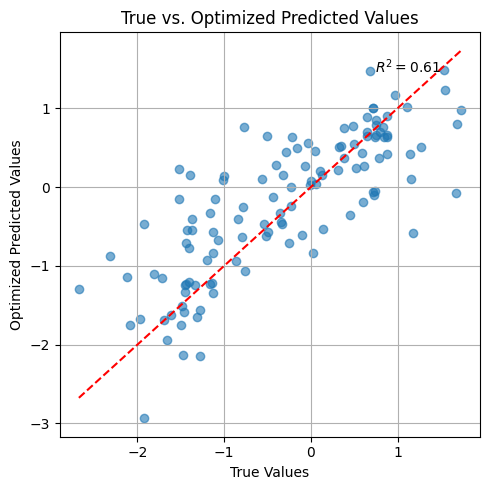

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_optimized_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--') # y=x
plt.xlabel("True Values")
plt.ylabel("Optimized Predicted Values")
plt.title("True vs. Optimized Predicted Values")
plt.text(0.75, 0.9, f'$R^2 = {r2:.2f}$', transform=plt.gca().transAxes)
plt.grid(True)
plt.tight_layout()
plt.show()